# Baseline CNN Model Training

**Objective:** Train and evaluate a baseline CNN model on the cyanobacteria toxicity
classification task. This notebook demonstrates:
- Loading and preprocessing data from splits
- Defining a simple CNN architecture
- Training with proper validation and early stopping
- Saving model checkpoints and training artifacts

## 1. Imports & Setup

In [1]:
import random
import shutil
import subprocess
from datetime import date
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import load_model

from src.config_utils import load_config
from src.data_loader import load_from_splits

## 2. Configuration & Parameters

In [2]:
# Load configuration
cfg = load_config('../configs/config_baseline.yaml')

# Set seeds for reproducibility
def set_seeds(seed):
    """Set seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(cfg['seed'])

# Parameters from config
DATA_DIRS = {
    'raw': Path(cfg['data']['raw_dir']),
    'processed': Path(cfg['data']['processed_dir'])
}
IMG_SIZE = tuple(cfg['preprocessing']['target_size'])
BATCH_SIZE = cfg['training']['batch_size']
EPOCHS = cfg['training']['epochs']
LEARNING_RATE = cfg['training']['learning_rate']

# Split files paths
SPLITS = {
    'train': Path('../splits/all/baseline/train.txt'),
    'val': Path('../splits/all/baseline/val.txt')
}

# Generate unique run ID
today = date.today().isoformat()
commit = subprocess.check_output(['git','rev-parse','--short','HEAD']).decode().strip()
run_id = f"{today}_{commit}"

# Prepare output directories
OUTPUT_DIRS = {
    'checkpoints': Path('../outputs/checkpoints/all/baseline'),
    'configs': Path('../outputs/configs/all/baseline'),
    'figures': Path('../outputs/figures/all/baseline'),
    'logs': Path('../outputs/logs/all/baseline')
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"Run ID: {run_id}")

Run ID: 2025-07-27_3319866


## 3. Data Loading & Preprocessing

In [3]:
# Build tf.data.Datasets from splits
train_ds, class_indices = load_from_splits(
    SPLITS['train'],
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

val_ds, _ = load_from_splits(
    SPLITS['val'],
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

num_classes = len(class_indices)
print(f"Class indices: {class_indices}")
print(f"Dataset sizes - Train: {train_ds.cardinality().numpy()}, Val: {val_ds.cardinality().numpy()}")

Class indices: {'non_toxic': 0, 'toxic': 1}
Dataset sizes - Train: 13, Val: 3


## 4. Model Architecture

In [4]:
def build_baseline_cnn(input_shape: tuple, num_classes: int) -> tf.keras.Model:
    """
    Build a simple baseline CNN architecture for toxicity classification.

    Args:
        input_shape: Input image shape (height, width, channels)
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        tf.keras.Input(shape=input_shape),
        # First conv block
        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        # Second conv block
        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),
        # Global pooling and dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_baseline_cnn(IMG_SIZE + (3,), num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,970 (109.26 KB)

 Trainable params: 27,970 (109.26 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Training Setup & Execution

In [5]:
# Prepare callbacks
callbacks_list = [
    # Model checkpoint - save best weights
    callbacks.ModelCheckpoint(
        filepath=OUTPUT_DIRS['checkpoints'] / f"{run_id}_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode="max"
    ),
    # Early stopping
    callbacks.EarlyStopping(
        **cfg['training']['early_stopping'],
        restore_best_weights=True
    )
]

# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Epoch 1/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5497 - loss: 0.6898 - val_accuracy: 0.6364 - val_loss: 0.6776
Epoch 2/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.6052 - loss: 0.6829 - val_accuracy: 0.6364 - val_loss: 0.6770
Epoch 3/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5730 - loss: 0.6847 - val_accuracy: 0.6364 - val_loss: 0.6745
Epoch 4/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.5328 - loss: 0.6929 - val_accuracy: 0.6364 - val_loss: 0.6706
Epoch 5/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.5665 - loss: 0.6826 - val_accuracy: 0.6364 - val_loss: 0.6638
Epoch 6/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.5677 - loss: 0.6757 - val_accuracy: 0.6364 - val_loss: 0.6506
Epoch 7/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.5531 - loss: 0.6882 - val_accuracy: 0.6364 - val_loss: 0.6590
Epoch 8/40
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.5943 - loss: 0.6693 - val_accuracy: 0.

## 6. Results Visualization & Saving

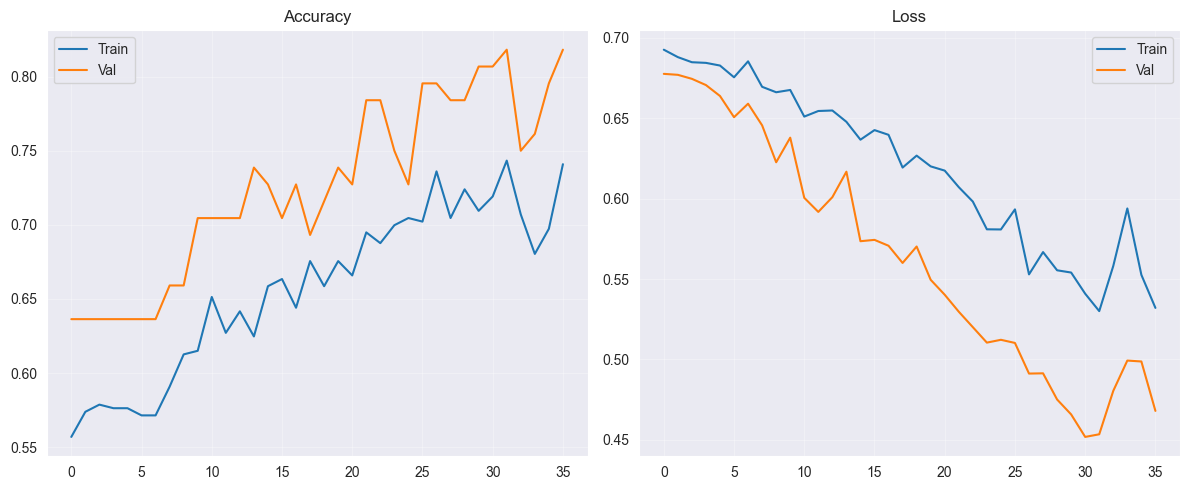

Training curves saved to: ../outputs/figures/all/2025-07-27_3319866_training_curves.png
Metrics saved to: ../outputs/logs/all/2025-07-27_3319866_metrics.txt


PosixPath('../outputs/configs/all/2025-07-27_3319866_config_baseline.yaml')

In [6]:
def plot_training_curves(history: dict, save_path: Path) -> None:
    """
    Plot and save training curves.

    Args:
        history: Training history dictionary
        save_path: Path to save the figure
    """
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train")
    plt.plot(history.history["val_accuracy"], label="Val")
    plt.legend()
    plt.title("Accuracy")
    plt.grid(True, alpha=0.3)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train")
    plt.plot(history.history["val_loss"], label="Val")
    plt.legend()
    plt.title("Loss")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Save training curves
curves_path = OUTPUT_DIRS['figures'] / f"{run_id}_training_curves.png"
plot_training_curves(history, curves_path)
print(f"Training curves saved to: {curves_path}")

# Save metrics
metrics_path = OUTPUT_DIRS['logs'] / f"{run_id}_metrics.txt"
with open(metrics_path, 'w') as f:
    for metric, values in history.history.items():
        f.write(f"{metric}: {values}\n")
print(f"Metrics saved to: {metrics_path}")

# Save config
shutil.copy(
    '../configs/config_baseline.yaml',
    OUTPUT_DIRS['configs'] / f"{run_id}_config_baseline.yaml"
)

## 7. Model Testing

In [7]:
def test_prediction(model_path: Path, img_path: Path, class_indices: dict) -> None:
    """
    Test model prediction on a single image.

    Args:
        model_path: Path to saved model
        img_path: Path to test image
        class_indices: Dictionary mapping class names to indices
    """
    # Load model
    model = load_model(model_path)

    # Load and preprocess image
    img = Image.open(img_path).resize(IMG_SIZE)
    x = np.array(img) / 255.0

    # Predict
    pred = model.predict(x[np.newaxis])[0]
    pred_idx = np.argmax(pred)

    # Convert index to class name
    inv_class_map = {v: k for k, v in class_indices.items()}
    pred_label = inv_class_map[pred_idx]

    print(f"Predicted class: {pred_label} (index {pred_idx})")
    print(f"Confidence: {pred[pred_idx]:.2%}")

# Test prediction on example image
latest_model = max(OUTPUT_DIRS['checkpoints'].glob('*.keras'))
test_img = Path('../data/processed/all/toxic/souche_1_scene2_fiji.tif')
test_prediction(latest_model, test_img, class_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: toxic (index 1)
Confidence: 67.34%
